# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

  



In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# read in the json files
%matplotlib inline
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [3]:
#check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

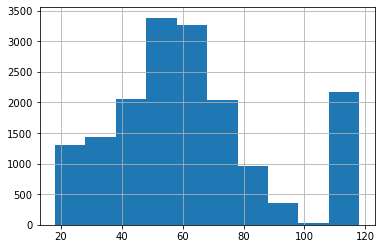

In [4]:
#check distribution of age column
profile.age.hist()

In [5]:
#having values of age as 118 is awkward
# Removing them
remove = profile[profile.age == 118]
profile = profile[profile.age < 118].reset_index(drop=True)
# converting to datetime as well
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [6]:
#storing 0s and 1s in new columns 
profile['missing'] = profile['age'].apply(lambda val: 1 if pd.isna(val) else 0)
dropped = profile[profile['missing'] == 1].index
# cleaned Dataset
clean_profile = profile.drop(dropped)

In [7]:
clean_profile.head()

,gender,age,id,became_member_on,income,missing
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0


## Data Analysis

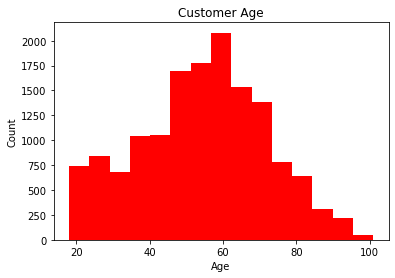

In [8]:
plt.hist(clean_profile['age'], bins = 15, color = 'red');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age');

#### Having most number of ages between 50-60 makes us sure that the data is legit

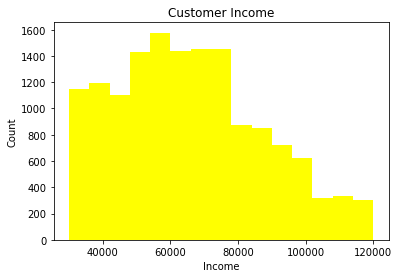

In [9]:
plt.hist(clean_profile['income'], bins = 15, color = 'yellow');
plt.xlabel('Income');
plt.ylabel('Count');
plt.title('Customer Income');

#### The data is having the mean income around 65000 which is correct for a huge population  

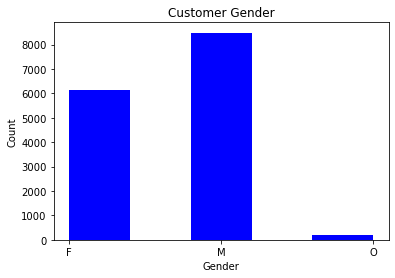

In [10]:
plt.hist(clean_profile['gender'],  bins = 5,color = 'blue');
plt.xlabel('Gender');
plt.ylabel('Count');
plt.title('Customer Gender');

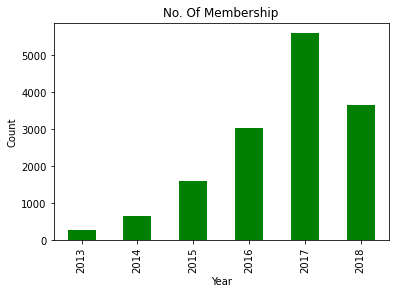

In [11]:
#One can notice that most customers are male
# One can now group people by their year of membership
clean_profile['membership_year'] = profile['became_member_on'].dt.year
mem_plot = clean_profile.groupby('membership_year').count()['id']
mem_plot.plot(kind = 'bar', color = 'green')
plt.title('No. Of Membership')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

### Preparation

In [12]:
x1 = transcript[transcript.event == 'transaction']
x2 = transcript[transcript.event == 'offer received']
x3 = transcript[transcript.event == 'offer viewed']
x4 = transcript[transcript.event == 'offer completed']
x1['amount'] = x1.value.apply(lambda x:list(x.values())[0])
x2['offer_id'] = x2.value.apply(lambda x:list(x.values())[0])
x3['offer_id'] = x3.value.apply(lambda x:list(x.values())[0])
x4['offer_id'] = x4.value.apply(lambda x:list(x.values())[0])
x4['reward'] = x4.value.apply(lambda x:list(x.values())[1])
transcript = pd.concat([x1,x2,x3,x4])
transcript = transcript[['event' , 'person' , 'offer_id' ,'time', 'amount' , 'reward' , 'value']]
transcript.drop(columns='value' , inplace=True)

In [13]:
transcript = pd.get_dummies(transcript , columns=['event'] , prefix='' ,prefix_sep='')
#dropping duplicates
transcript.drop_duplicates(inplace=True)

In [14]:
transcript.head()

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction
12654,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN,0,0,0,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN,0,0,0,1
12659,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN,0,0,0,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN,0,0,0,1
12671,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN,0,0,0,1


In [15]:
merged = pd.merge(transcript , profile ,left_on='person' , right_on='id',how='inner')
merged.drop(columns=['id'] , inplace=True)
# Fill nans with 0
merged.reward.fillna(0 , inplace=True)
merged.amount.fillna(0 , inplace=True)

In [16]:
# sort values
merged.sort_values(by=['time'] , ascending=True , inplace=True)

list1 = ['transaction', 'amount']

for i in list1:
    merged[i] = merged.groupby('person')[i].cumsum()

In [17]:
merged.dropna(subset=['offer_id'] ,inplace=True)
merged = merged.merge(portfolio , left_on='offer_id' , right_on='id'  ,how='left')

In [18]:
Model_data = merged.groupby(['person' , 'offer_type']).agg(
    {
         'offer completed':sum,   
         'offer received': sum, 
         'offer viewed': sum,  
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last'
    }
).reset_index()

In [19]:
merged.head()

,person,offer_id,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,gender,age,became_member_on,income,missing,reward_y,channels,difficulty,duration,offer_type,id
0,a5c24057de1147a798422162559bbe83,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0.0,0.0,0,1,0,0,M,33,2018-06-12,45000.0,0,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
1,84eb11751c674c5ab910f3bebe78586d,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.0,0.0,0,1,0,0,M,73,2013-11-15,63000.0,0,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,8dc17515545e42d9a2974a3aebc3aa69,fafdcd668e3743c1bb461111dcafc2a4,0,0.0,0.0,0,1,0,0,M,61,2018-06-08,43000.0,0,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
3,a5675e02cac04aefb87d21551a3dfa8c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,0.0,0,1,0,0,M,42,2017-11-20,54000.0,0,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
4,3339d9d8f5ff4664bd259572330c5dbf,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,1,0,0,M,62,2014-11-05,44000.0,0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [20]:
def offers_transformation(df):
    '''
    Function: to transform the offers
    
    Returns: The transformed offers
    '''
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0

    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_completed'] = row['offer completed']
            df.loc[index , 'bogo_received'] = row['offer received']

        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_completed'] = row['offer completed']
            df.loc[index , 'discount_received'] = row['offer received']
        
        
        
    return df.groupby(['person']).agg(
    {
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum,        
    }
).reset_index()

In [21]:
trans_data = offers_transformation(Model_data)

In [22]:
trans_data.head()

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3


In [23]:
# create colunms with the percentage of each offer
trans_data['bogo_percentage'] = trans_data.bogo_completed.div(trans_data.bogo_received.where(trans_data.bogo_received != 0, np.nan))*100
trans_data['discount_percentage'] = trans_data.discount_completed.div(trans_data.discount_received.where(trans_data.discount_received != 0, np.nan))*100

In [24]:
trans_data.fillna(0 , inplace=True)

In [25]:
trans_data.isna().sum()

person                 0
age                    0
became_member_on       0
gender                 0
income                 0
bogo_received          0
bogo_completed         0
discount_received      0
discount_completed     0
bogo_percentage        0
discount_percentage    0
dtype: int64

In [26]:
trans_data['bogo_offer'] = 0
trans_data['discount_offer'] = 0


for i ,row in trans_data.iterrows():

    if(row['bogo_percentage'] >= 80):
        trans_data.loc[i , 'bogo_offer'] = 1
        
    if(row['discount_percentage'] >= 80 ):
        trans_data.loc[i , 'discount_offer'] = 1

In [27]:
trans_data

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed,bogo_percentage,discount_percentage,bogo_offer,discount_offer
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2,100.000000,100.000000,1,1
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2,100.000000,100.000000,1,1
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2,50.000000,100.000000,0,1
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1,100.000000,100.000000,1,1
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3,0.000000,100.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,fff3ba4757bd42088c044ca26d73817a,69,2015-09-20,F,83000.0,1,1,3,2,100.000000,66.666667,1,0
14816,fff7576017104bcc8677a8d63322b5e1,71,2017-10-31,M,73000.0,3,1,2,2,33.333333,100.000000,0,1
14817,fff8957ea8b240a6b5e634b6ee8eafcf,71,2018-02-18,M,56000.0,1,0,1,0,0.000000,0.000000,0,0
14818,fffad4f4828548d1b5583907f2e9906b,34,2017-01-23,M,34000.0,3,3,0,0,100.000000,0.000000,1,0


##### Data Modelling

In [28]:
Model_data2 = trans_data.copy()
Model_data2['year'] = Model_data2.became_member_on.dt.year
Model_data2['month'] = Model_data2.became_member_on.dt.month

In [29]:
Model_data2 = Model_data2[['age' , 'gender' , 'income' ,
                           'year' , 'month' , 'discount_offer' ,
                           'bogo_offer']]

In [30]:
Model_data3 = pd.get_dummies(Model_data2 , columns=['gender'])

In [31]:
X = Model_data3.drop(columns=['discount_offer' ,'bogo_offer'])
y_bogo = Model_data3.bogo_offer
y_discount = Model_data3.discount_offer

In [68]:
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=10)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=10)

In [71]:
model1_bogo = KNeighborsClassifier()
model1_discount = KNeighborsClassifier()
model1_bogo.fit(X_train, y_bogo_train)
model1_discount.fit(X_train, y_discount_train)

KNeighborsClassifier()

In [72]:
print('Bogo offer F1_score {}'.format( model1_bogo.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(model1_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model1_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model1_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.597480881691408
Bogo offer Test F1_score 0.5560053981106613
Discount offer Training F1_score 0.7108412055780476
Discount offer Test F1_score 0.5454790823211876


In [73]:
model2_bogo = RandomForestClassifier()
model2_discount = RandomForestClassifier()
model2_bogo.fit(X_train, y_bogo_train)
model2_discount.fit(X_train, y_discount_train)

RandomForestClassifier()

In [74]:
print('Bogo offer F1_score {}'.format( model2_bogo.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(model2_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model2_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model2_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.6641475483580747
Bogo offer Test F1_score 0.6099865047233468
Discount offer Training F1_score 0.9915429599640126
Discount offer Test F1_score 0.6269905533063428


In [75]:
model3_bogo = DecisionTreeClassifier()
model3_discount = DecisionTreeClassifier()
model3_bogo.fit(X_train, y_bogo_train)
model3_discount.fit(X_train, y_discount_train)

DecisionTreeClassifier()

In [76]:
print('Bogo offer F1_score {}'.format( model3_bogo.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(model3_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model3_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model3_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.6641475483580747
Bogo offer Test F1_score 0.5802968960863698
Discount offer Training F1_score 0.9915429599640126
Discount offer Test F1_score 0.5705802968960864


In [77]:
model4_bogo = GradientBoostingClassifier()
model4_discount = GradientBoostingClassifier()
model4_bogo.fit(X_train, y_bogo_train)
model4_discount.fit(X_train, y_discount_train)

GradientBoostingClassifier()

In [78]:
print('Bogo offer F1_score {}'.format( model4_bogo.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(model4_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model4_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model4_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.654251012145749
Bogo offer Test F1_score 0.6488529014844804
Discount offer Training F1_score 0.6773729194781827
Discount offer Test F1_score 0.6469635627530365


In [81]:
model5_bogo = GradientBoostingClassifier()
model5_discount = ExtraTreesClassifier()
model5_bogo.fit(X_train, y_bogo_train)
model5_discount.fit(X_train, y_discount_train)

ExtraTreesClassifier()

In [82]:
print('Bogo offer F1_score {}'.format( model5_bogo.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(model5_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model5_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model5_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.654251012145749
Bogo offer Test F1_score 0.6488529014844804
Discount offer Training F1_score 0.9915429599640126
Discount offer Test F1_score 0.611336032388664


In [54]:
model6_bogo = AdaBoostClassifier()
model6_discount = AdaBoostClassifier()
model6_bogo.fit(X_train, y_bogo_train)
model6_discount.fit(X_train, y_discount_train)

AdaBoostClassifier()

In [55]:
print('Bogo offer F1_score {}'.format( model6_bogo.score(X_train,y_discount_train)))
print('Bogo offer Test F1_score {}'.format(model6_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(model6_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(model6_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.6369770580296896
Bogo offer Test F1_score 0.6464237516869096
Discount offer Training F1_score 0.652991452991453
Discount offer Test F1_score 0.6620782726045884


In [104]:
def get_predict(customer , offer):
    '''
    Function: to get the prediction
    
    Input: customer, offer
    
    output: prediction
    
    '''
    predict_bogo = 0
    predict_discount = 0 
    

    predict_bogo = model4_bogo.predict(customer.values)[0]
    predict_discount = model4_discount.predict(customer.values)[0]
    
    if(predict_bogo == 0 & predict_discount == 0):
        print('No Response!')

        
    if (offer == 'bogo'):
        if(predict_bogo == 0):
            if(predict_discountt == 1):
                print('preferred discount')           
        else:
            print('Bogo choice')
    if (offer == 'discount'):
        if(predict_discount == 0):
            if(predict_bogo == 1):
                print('preferred bogo')           
        else:
            print('Discount choice')

In [106]:
get_predict(X_test[1:8] ,'discount')

Discount choice


### Discussion
##### The highest accuracy on the training test was found to be 99.2%by Extra Tree classifier and Decision Tree Classifier, moreover Extra Tree Classifier is preferred due to the fact that it has more accuracy on test data as well, the best accuracy on test data was found to be 67% by Gradient Boost Classifier, the less accuracy can be attributed to the complexity of the dataset.
##### The company can focus on bringing on more younger customers and look to harness people from their 50 -60 years base. Owing to the complexity of the dataset one can expect the test accuracy of the model to be around 67%. This model is basically about sending offers to people, so this amount of accuracy is fair enough.